In [1]:
# Import PyTorch
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
from torch import nn  # All neural network modules
from torch import optim  # For optimizers like SGD, Adam, etc.

# Import torchvision
import torchvision

from torchvision import transforms # Transformations we can perform on our dataset for augmentation
from torchvision import datasets  # Standard datasets
from torch.utils.data import DataLoader # Gives easier dataset managment by creating mini batches etc.
from torchvision.transforms import ToTensor 

# Import matplotlib for visualization
import matplotlib.pyplot as plt

from utils import accuracy_fn


# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.1.2
0.16.2


In [2]:
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # do we want the training dataset?
    download=True, # do we want to download yes/no?
    transform=torchvision.transforms.ToTensor(), # how do we want to transform the data?
    target_transform=None # how do we want to transform the labels/targets?
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False, # train=False -> Download the test data 
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [62]:
image, label = train_data[0]
print(image.shape)
print(label)
# image, label

torch.Size([1, 28, 28])
9


In [4]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [61]:
train_data.targets # get all target labels in the dataset

tensor([9, 0, 0,  ..., 3, 0, 5])

In [65]:
# Check the shape of our image
print(f"Image shape: {image.shape} -> [color_channels, height, width]") 
print(f"Image target label: {label}")
print(f"Image: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image target label: 9
Image: Ankle boot


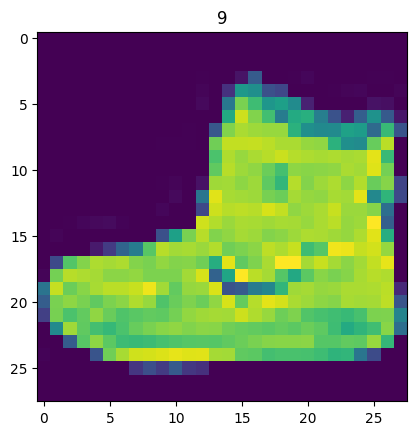

In [69]:
image, label = train_data[0]
plt.imshow(image.squeeze())
plt.title(label);

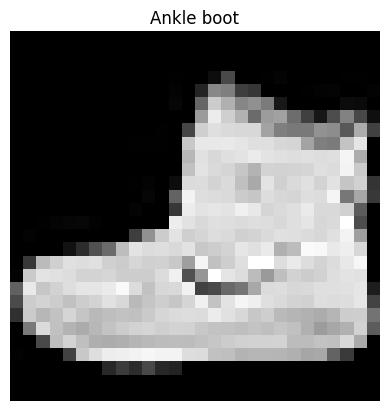

In [70]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);
plt.axis(False);

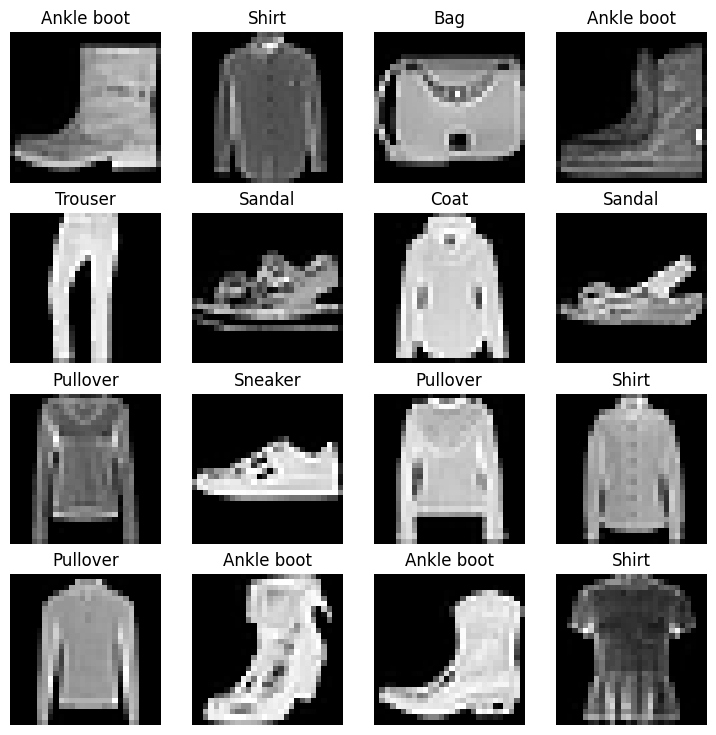

In [78]:
# Plot more images
torch.manual_seed(42)

fig = plt.figure(figsize=(9, 9))

rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i) # add subplot on figure
    plt.imshow(img.squeeze(), cmap="gray") # plot the actual image on that subplot
    plt.title(class_names[label])
    plt.axis(False)
    
    

In [75]:
random_idx = torch.randint(0, len(train_data), size=[3])
random_idx

tensor([46876, 46414, 10026])

In [81]:
# Setup the batch size hyperparameter
BATCH_SIZE = 32


# Dataloader turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x3381cd1d0>,
 <torch.utils.data.dataloader.DataLoader at 0x338709010>)

In [84]:
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}... Each one of {len(train_dataloader)} batches contain {BATCH_SIZE} images ")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")
     

Length of train_dataloader: 1875 batches of 32... Each one of 1875 batches contain 32 images 
Length of test_dataloader: 313 batches of 32...


In [164]:
print(len(train_dataloader)) # -> number of batches
len(train_dataloader.dataset) # -> total number of training exampels across all batches

1875


60000

In [92]:
next(iter(train_dataloader))[0].shape, next(iter(train_dataloader))[1].shape



(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [96]:
train_features_batch1, train_labels_batch1 = next(iter(train_dataloader))

train_features_batch1.shape, train_labels_batch1.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [97]:
train_features_batch1[0].shape

torch.Size([1, 28, 28])

(-0.5, 27.5, 27.5, -0.5)

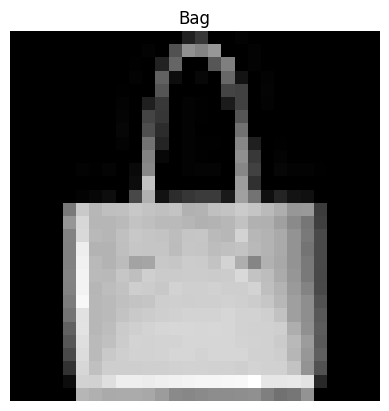

In [100]:
# Show a sample
# torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch1), size=[1]).item()
img, label = train_features_batch1[random_idx], train_labels_batch1[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

In [102]:
# Create a flatten layer
flatten_model = nn.Flatten() 

x = train_features_batch1

# Flatten the batch of 32 images each 1 x 28 x 28
output = flatten_model(x) # perform forward pass


x.shape, output.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32, 784]))

In [133]:
dummy_x = train_features_batch1[0][0]
print(dummy_x.shape)

flatten_model(dummy_x).shape

torch.Size([28, 28])


torch.Size([28, 28])

In [106]:
# Print out what happened
print(f"Shape before flattening: {x.shape} -> [num_images, color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [num_images, color_channels * height * width]")

Shape before flattening: torch.Size([32, 1, 28, 28]) -> [num_images, color_channels, height, width]
Shape after flattening: torch.Size([32, 784]) -> [num_images, color_channels * height * width]


In [114]:
class FashionMNISTModel(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Flatten(), # Flattens the 1 x 28 x 28 images into a vector of length 784 (1 * 28 * 28)
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
        
    def forward(self, x):
        return self.linear_stack(x)
    

In [9]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [115]:
torch.manual_seed(42)

model_0 = FashionMNISTModel(
    input_shape = 28 * 28, # 28 * 28 = 784
    hidden_units = 10,
    output_shape = len(class_names) # number of classes
).to(device)

In [119]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x).shape

torch.Size([1, 10])

In [121]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [17]:
# Example of timing our functions or code

from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float, 
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time




start_time = timer()
# some code...
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")


Train time on cpu: 0.000 seconds


1.6709003830328584e-05

In [18]:
from tqdm.auto import tqdm

/Users/saalikmubeen/Dev/Machine Learning/personal-learning/venv/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [149]:
print(next(iter(train_dataloader))[0].shape)

torch.Size([32, 1, 28, 28])


In [159]:
# first_batch_x = next(iter(train_dataloader))[0]
# first_batch_y = next(iter(train_dataloader))[0]

first_batch_x, first_batch_y = next(iter(train_dataloader))
y_pred_logits = model_0(first_batch)

print("y_pred_logits.shape: ", y_pred_logits.shape)
print("first_batch_y.shape: ", first_batch_y.shape)


# Convert model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_pred_logits, dim=1)
print(y_pred_probs.shape)

print(y_pred_probs.sum(dim=1, keepdims=True)[0:10])

# Find the index where probability is max
print(torch.argmax(y_pred_probs, dim=1, keepdims=True)[0:10])

# Convert our model's prediction probabilities to prediction labels
y_pred_labels = torch.argmax(y_pred_probs, dim=1)

print("y_pred_labels.shape: ", y_pred_labels.shape)

print("Predctions:")
print(y_pred_labels[0:10])

print("Targets:")
print(first_batch_y[0:10])

y_pred_logits.shape:  torch.Size([32, 10])
first_batch_y.shape:  torch.Size([32])
torch.Size([32, 10])
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], grad_fn=<SliceBackward0>)
tensor([[0],
        [8],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])
y_pred_labels.shape:  torch.Size([32])
Predctions:
tensor([0, 8, 0, 0, 0, 0, 0, 0, 0, 0])
Targets:
tensor([4, 5, 0, 4, 6, 9, 3, 7, 7, 2])


In [169]:
# Training Loop


# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer() 

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 10

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n------")
    
    ### Training
    train_loss = 0 # Total loss for one epoch
    train_acc = 0  # Total acc for one epoch
    
    for batch, (X, y) in enumerate(train_dataloader):
        
        model_0.train()
        
        # Forward pass
        # X is a tensor of 32 images i,e 
        # X -> 32 x 1 x 28 x 28
        y_pred_logits = model_0.forward(X) # shape = torch.Size([32, 10])
        
        #  Calculate loss (per batch)
        loss = loss_fn(y_pred_logits, y) # loss per batch
        train_loss += loss # accumulate train loss
        
        y_pred_probs = torch.softmax(y_pred_logits, dim=1)
        y_pred_labels = torch.argmax(y_pred_probs, dim=1) # shape -> torch.Size([32])
        
        # Accuracy
        acc = accuracy_fn(y_true=y, y_pred=y_pred_labels)
        train_acc += acc
        
        # Zero grad
        optimizer.zero_grad()
        
        # Backward Propagation
        loss.backward()
        
        # Gradient Descent
        optimizer.step()
        
        # Print out what's happening
        # len(train_dataloader) -> number of batches
        # len(train_dataloader.dataset) -> total number of training exampels across all batches
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")
       
    # Divide total train loss by length of train dataloader
    # to calculate train loss average per batch
    # length of train dataloader = number of batches
    train_loss = train_loss / len(train_dataloader)
    
    train_acc /= len(train_dataloader)
    
    # Testing
    model_0.eval()
        
    test_loss, test_acc = 0, 0
        
    with torch.inference_mode():
            
        for X_test, y_test in test_dataloader:
                
            # Forward pass
            y_test_logits = model_0(X_test)
                
            # Test Loss for each batch
            test_batch_loss = loss_fn(y_test_logits, y_test)
            test_loss += test_batch_loss
                
            y_test_probs = torch.softmax(y_test_logits, dim=1)
            y_test_labels = torch.argmax(y_test_probs, dim=1) # shape -> torch.Size([32])
                
            # Calculate accuracy
            acc = accuracy_fn(y_true=y_test, y_pred=y_test_labels)
            test_acc += acc
            
        test_loss = test_loss / len(test_dataloader)
        
        test_acc = test_acc / len(test_dataloader)
        
    # Print out what's happening after end of each epoch
    # This is the end of each epcoh of out training loop.
    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")
        
                
# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))

Epoch: 0
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4287 | Test loss: 0.4696, Train acc: 10.0033, Test acc: 83.5863
Epoch: 1
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4243 | Test loss: 0.5032, Train acc: 9.9633, Test acc: 82.5180
Epoch: 2
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4233 | Test loss: 0.5360, Train acc: 9.9500, Test acc: 82.2983
Epoch: 3
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4219 | Test loss: 0.4668, Train acc: 10.0050, Test acc: 83.2768
Epoch: 4
------
Lo

### Functionizing training and evaluation/testing loops

In [24]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, 
               accuracy_fn
              ):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:  # for X, y in tqdm(data_loader):
        
      # Make predictions
      # Forward pass
      y_logits = model(X)
      
      y_probs = torch.softmax(y_logits, dim=1)
      y_pred = torch.argmax(y_probs, dim=1)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_logits, y)
    
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred)

    # Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

In [23]:
torch.manual_seed(42)


# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn, 
                             accuracy_fn=accuracy_fn)
model_0_results


NameError: name 'model_0' is not defined

In [178]:

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """Performs a training with model trying to learn on data_loader."""
  train_loss, train_acc = 0, 0

  # Put model into training mode
  model.train()

  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):
    # Put data on target device 
    X, y = X.to(device), y.to(device)

    # 1. Forward pass (outputs the raw logits from the model)
    y_logits = model(X)
    
    # go from logits -> prediction labels
    y_probs = torch.softmax(y_logits, dim=1)
    y_pred = torch.argmax(y_probs, dim=1)
    
    # 2. Calculate loss and accuracy (per batch)
    loss = loss_fn(y_logits, y)
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward
    loss.backward()
    
    # 5. Optimizer step (update the model's parameters once *per batch*)
    optimizer.step()
  
  # Divide total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [179]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Performs a testing loop step on model going over data_loader."""
  test_loss, test_acc = 0, 0
  
  # Put the model in eval mode
  model.eval()

  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # Send the data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass (outputs raw logits)
      test_logits = model(X)
        
      # go from logits -> prediction labels 
      test_probs = torch.softmax(test_logits, dim=1)
      y_pred = test_probs.argmax(dim=1)
    

      # 2. Calculuate the loss/acc
      test_loss += loss_fn(test_logits, y)
      test_acc += accuracy_fn(y_true=y, y_pred=y_pred) 

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

In [180]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# Set epochs
epochs = 3

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in range(epochs): # for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n----------")
  train_step(model=model_0,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
    
  test_step(model=model_0,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_on_gpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

Epoch: 0
----------
Train loss: 0.41360 | Train acc: 85.37%
Test loss: 0.47006 | Test acc: 83.57%

Epoch: 1
----------
Train loss: 0.41043 | Train acc: 85.58%
Test loss: 0.49086 | Test acc: 82.92%

Epoch: 2
----------
Train loss: 0.41056 | Train acc: 85.58%
Test loss: 0.52794 | Test acc: 82.51%

Train time on cpu: 7.300 seconds


# Convolutional Neural Networks (CNN)

 ###  Stepping through nn.Conv2d()

In [213]:
torch.manual_seed(42)

# Create a batch of images
images = torch.randn(size=(32, 3, 64, 64)) # 3 channels 
test_image = images[0] 


print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])


In [215]:
torch.manual_seed(42)

# Create a sinlge conv2d layer
conv_layer = nn.Conv2d(
    in_channels=3,
    out_channels=10, # use/apply 10 kernels/filters
    kernel_size=(3, 3),
    stride=1,
    padding=0
)

# Output shape -> floor([n + 2p - f / s] + 1)
# shape = (64 + 0 - 3) / 1 + 1 = 62 

conv_output = conv_layer(images)
conv_output.shape

torch.Size([32, 10, 62, 62])

### Stepping through nn.MaxPool2d()

In [216]:
# Create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(images)
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")
     

Shape after going through conv_layer(): torch.Size([32, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([32, 10, 31, 31])


In [225]:
import math

def calculate_conv_output_size(n, f, p=0, s=1):
    """
    Calculates the output size given input size (n), filter size (f), padding size (p) and stride (s).
    """
    return math.floor(((n - f + 2 * p) / s) + 1)

In [7]:
class FashionMNISTModel2(nn.Module):
    
    def __init__(self, input_channels, output_channels, output_shape):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
           nn.Conv2d(
               in_channels=input_channels, 
               out_channels=output_channels,
               kernel_size=(3, 3),
               stride=1,
               padding=0),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=output_channels,
                out_channels=output_channels,
                kernel_size=(3, 3),
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        
        self.conv_block_2 = nn.Sequential(
           nn.Conv2d(
               in_channels=output_channels, 
               out_channels=output_channels,
               kernel_size=(3, 3),
               stride=1,
               padding=0),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=output_channels,
                out_channels=output_channels,
                kernel_size=(3, 3),
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.linear = nn.Sequential(
           nn.Flatten(),
           nn.Linear(
              in_features = 160 ,
              out_features = output_shape
           )
        )
        
        
    
    def forward(self, x):
        z = self.conv_block_1(x)
        z = self.conv_block_2(z)
        # print(z.shape)
        z = self.linear(z)
        # l = nn.Flatten()
        # return l(z)
        return z

In [10]:
torch.manual_seed(42)
model_1 = FashionMNISTModel2(input_channels=1, # rgb channels (only one for black and white images)
                             output_channels=10,
                             output_shape=len(class_names) # number of classes in the dataset
                            ).to(device)


In [11]:
train_features_batch1, train_labels_batch1 = next(iter(train_dataloader))

train_features_batch1.shape, train_labels_batch1.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [12]:
model_1(train_features_batch1).shape

torch.Size([32, 10])

In [14]:
y_pred_logits = model_1(train_features_batch1)

print("y_pred_logits.shape: ", y_pred_logits.shape)
print("first_batch_y.shape: ", train_labels_batch1.shape)


# Convert model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_pred_logits, dim=1)
print(y_pred_probs.shape)

print(y_pred_probs.sum(dim=1, keepdims=True)[0:10])

# Find the index where probability is max
print(torch.argmax(y_pred_probs, dim=1, keepdims=True)[0:10])

# Convert our model's prediction probabilities to prediction labels
y_pred_labels = torch.argmax(y_pred_probs, dim=1)

print("y_pred_labels.shape: ", y_pred_labels.shape)

print("Predctions:")
print(y_pred_labels[0:10])

print("Targets:")
print(train_labels_batch1[0:10])

y_pred_logits.shape:  torch.Size([32, 10])
first_batch_y.shape:  torch.Size([32])
torch.Size([32, 10])
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], grad_fn=<SliceBackward0>)
tensor([[8],
        [8],
        [8],
        [9],
        [9],
        [9],
        [8],
        [8],
        [9],
        [8]])
y_pred_labels.shape:  torch.Size([32])
Predctions:
tensor([8, 8, 8, 9, 9, 9, 8, 8, 9, 8])
Targets:
tensor([0, 5, 5, 5, 4, 3, 0, 4, 6, 5])


In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [21]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
train_time_start_model_1 = timer()

# Train and test model
epochs = 3

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n------")
    
    ### Training
    train_loss = 0 # Total loss for one epoch
    train_acc = 0  # Total acc for one epoch
    
    for batch, (X, y) in enumerate(train_dataloader):
        
        model_1.train()
        
        # Forward pass
        # X is a tensor of 32 images i,e 
        # X -> 32 x 1 x 28 x 28
        y_pred_logits = model_1.forward(X) # shape = torch.Size([32, 10])
        
        #  Calculate loss (per batch)
        loss = loss_fn(y_pred_logits, y) # loss per batch
        train_loss += loss # accumulate train loss
        
        y_pred_prob = torch.softmax(y_pred_logits, dim=1)
        y_pred_labels = torch.argmax(y_pred_probs, dim=1) # shape -> torch.Size([32])
        
        # Accuracy
        acc = accuracy_fn(y_true=y, y_pred=y_pred_labels)
        train_acc += acc
        
        # Zero grad
        optimizer.zero_grad()
        
        # Backward Propagation
        loss.backward()
        
        # Gradient Descent
        optimizer.step()
        
        # Print out what's happening
        # len(train_dataloader) -> number of batches
        # len(train_dataloader.dataset) -> total number of training exampels across all batches
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")
       
    # Divide total train loss by length of train dataloader
    # to calculate train loss average per batch
    # length of train dataloader = number of batches
    train_loss = train_loss / len(train_dataloader)
    
    train_acc /= len(train_dataloader)
    
    # Testing
    model_1.eval()
        
    test_loss, test_acc = 0, 0
        
    with torch.inference_mode():
            
        for X_test, y_test in test_dataloader:
                
            # Forward pass
            y_test_logits = model_1(X_test)
                
            # Test Loss for each batch
            test_batch_loss = loss_fn(y_test_logits, y_test)
            test_loss += test_batch_loss
                
            y_test_probs = torch.softmax(y_test_logits, dim=1)
            y_test_labels = torch.argmax(y_test_probs, dim=1) # shape -> torch.Size([32])
                
            # Calculate accuracy
            acc = accuracy_fn(y_true=y_test, y_pred=y_test_labels)
            test_acc += acc
            
        test_loss = test_loss / len(test_dataloader)
        
        test_acc = test_acc / len(test_dataloader)
        
    # Print out what's happening after end of each epoch
    # This is the end of each epcoh of out training loop.
    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")
        
                
# Calculate training time
train_time_end_model_1 = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_model_1,
                                            end=train_time_end_model_1,
                                            device=str(next(model_1.parameters()).device))

Epoch: 0
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.3248 | Test loss: 0.3586, Train acc: 10.1500, Test acc: 87.3802
Epoch: 1
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.3176 | Test loss: 0.3583, Train acc: 10.0100, Test acc: 86.9409
Epoch: 2
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.3104 | Test loss: 0.3331, Train acc: 9.9583, Test acc: 87.9593
Train time on cpu: 108.450 seconds


In [26]:
# Get model_2 results
model_1_results = eval_model(
     model=model_1,
     data_loader=test_dataloader,
     loss_fn=loss_fn,
     accuracy_fn=accuracy_fn,
)

model_1_results


{'model_name': 'FashionMNISTModel2',
 'model_loss': 0.33239251375198364,
 'model_acc': 87.97923322683707}

In [55]:

def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_labels = []
    model.to(device)
    
    with torch.inference_mode():
        
        for sample in data:
            # Prepare the sample (add a batch dimension and pass to target device)
            sample = torch.unsqueeze(sample, dim=0).to(device)
            
            # Forward pass (model outputs raw logits)
            pred_logit = model(sample)
            
            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            
            # Get prediction label (prediction probability -> prediction label)
            pred_label = torch.argmax(pred_prob)
            
            pred_labels.append(pred_label.item())
            
            
    return pred_labels


In [30]:
import random
random.sample([1, 2, 3, 4, 5], k=2)

[2, 3]

In [33]:
len(list(test_data))

10000

In [46]:
import random
# random.seed(42)
test_samples = [] 
test_labels = []
# Randomly select 9 images from the test data
for image, label in random.sample(list(test_data), k=9):
  test_samples.append(image)
  test_labels.append(label)

# View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Dress')

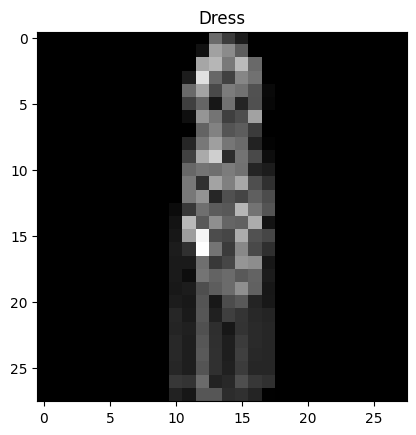

In [47]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [56]:
# Make predictions
pred_classes = make_predictions(model=model_1,
                              data=test_samples)

# View prediction probabilities
print("Predicted Labels: ", pred_classes)
print("Target Labels: ", test_labels)

Predicted Labels:  [3, 5, 7, 7, 0, 3, 2, 3, 4]
Target Labels:  [3, 5, 5, 7, 0, 3, 2, 3, 4]


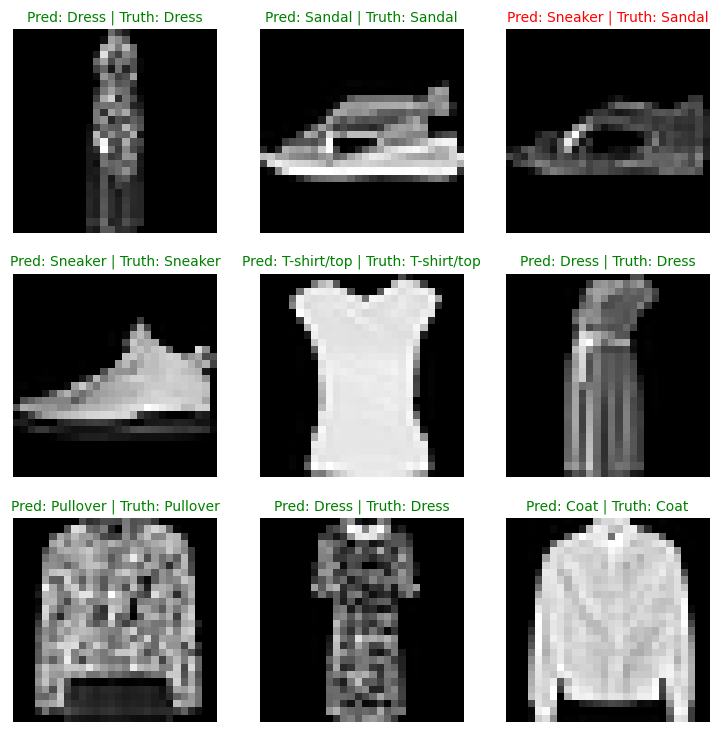

In [74]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction (in text form, e.g "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form) 
  truth_label = class_names[test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
  else:
    plt.title(title_text, fontsize=10, c="r") 
  
  plt.axis(False);

### Confusion Matrix

In [83]:
# 1. Make predictions with trained model
y_preds = []
model_1.eval()
with torch.inference_mode():
  for X, y in test_dataloader:
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)
    
    # Do the forward pass
    y_logit = model_1(X)
    
    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    
    # Put prediction on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of prediction tensors into a tensor
# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor, len(y_pred_tensor)

(tensor([9, 2, 1,  ..., 8, 1, 8]), 10000)

In [64]:
# See if required packages are installed and if not, install them...
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1] >= 19, "mlxtend version should be 0.19.0 or higher")
except:
  !pip install torchmetrics -U mlxtend 
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1
mlxtend version: 0.23.1


In [65]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [84]:
y_pred_tensor[:10]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [85]:
test_data.targets[:10]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

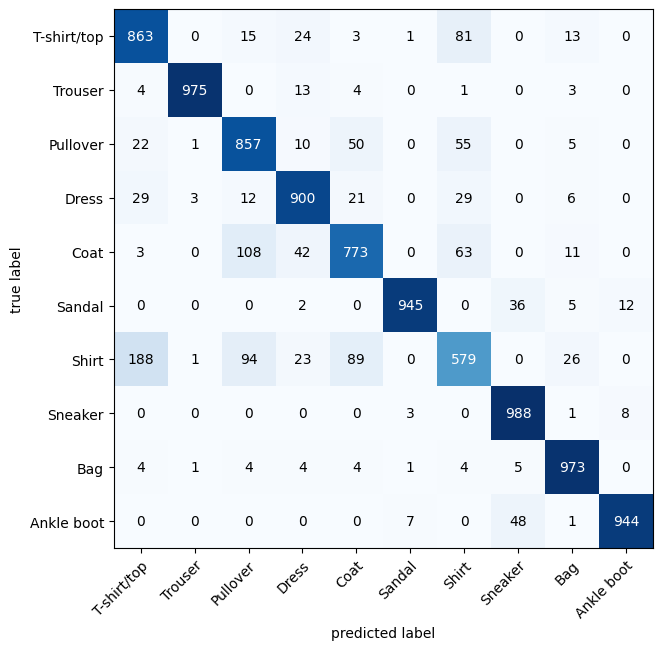

In [86]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with numpy
    class_names=class_names,
    figsize=(10, 7)
)

### Save and load the model

In [76]:
from pathlib import Path

# Create model dictory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "pytorch_computer_vision_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/pytorch_computer_vision_model.pth


In [79]:
# Create a new instance
torch.manual_seed(42)

loaded_model = FashionMNISTModel2(input_channels=1,
                                     output_channels=10,
                                     output_shape=len(class_names))

# Load in the save state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send the model to the target device
loaded_model.to(device)

FashionMNISTModel2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=160, out_features=10, bias=True)
  )
)

In [80]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_results = eval_model(
    model=loaded_model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)